In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sncosmo_vs_snana as ss
from sedfit.utils import register_bands_for_sncosmo
import glob
from scipy.interpolate import interp1d


In [3]:
register_bands_for_sncosmo()

In [4]:
salt2par_sncosmo = ss.sncosmo_fitres_to_df('data/fitres_sncosmo/salt2pars_all_sncosmo.dat')
salt2par_snana = ss.snana_fitres_to_df(glob.glob('data/fitres_snana/results/*.FITRES.TEXT'))
mjdrange_snana = ss.get_snana_fitmjd_range(glob.glob('data/fitres_snana/results/*.LCPLOT.TEXT'))
salt2par_snana = salt2par_snana.merge(mjdrange_snana,on=['CID','Survey'])
# salt2par_sncosmo['Name_upper'] = ['SN'+x.upper() for x in salt2par_sncosmo['Name']]
salt2par_snana['Name_upper'] = [x.upper() for x in salt2par_snana['CID']]

In [5]:
salt2par_sncosmo.to_csv('data/salt2par_all_sncosmo.csv')
salt2par_snana.to_csv('data/salt2par_all_snana.csv')

In [6]:
common_list = ss.commonElements([salt2par_sncosmo.Name_upper.unique(),salt2par_snana.Name_upper.unique()])

In [7]:
len(common_list),len(salt2par_sncosmo.Name_upper.unique()),len(salt2par_snana.Name_upper.unique())

(796, 812, 796)

In [8]:
difflist = set(list(salt2par_sncosmo.Name_upper.unique())) ^ set(list(salt2par_snana.Name_upper.unique()))

In [9]:
difflist

{'IPTF17DZ',
 'SN1999CW',
 'SN2001GC',
 'SN2002AR',
 'SN2003GQ',
 'SN2004K',
 'SN2005DF',
 'SN2005GJ',
 'SN2006DD',
 'SN2006MR',
 'SN2007FQ',
 'SN2007FS',
 'SN2008HA',
 'SN2009HP',
 'SN2010AE',
 'SN2011GU'}

In [10]:
# print('SN1999BH' in salt2par_sncosmo.Name_upper.unique())
# print('SN1999BH' in salt2par_snana.Name_upper.unique())

In [11]:
# plotlist = ['SN2005KU']
plotlist = common_list

In [12]:
from matplotlib.backends.backend_pdf import PdfPages
import gc
meta_df = pd.read_csv('data/snmeta_all.csv',index_col=0) 
lc_df = pd.read_csv('data/snlc_all.csv',index_col=0)
sn_per_pdf = 100

pdfs = {}
j = 0
f = open('plots/plotlist.txt','w')
for i,name in enumerate(np.sort(plotlist[0:])): #common_list:
    if i==0 and j == 0:
#         pdfs[0] = PdfPages('plots/plots_all_{:d}.pdf'.format(j))
#         pdf = pdfs[0]
        pdf = PdfPages('plots/plots_all_{:d}.pdf'.format(j))
    if i//sn_per_pdf>0 and i%sn_per_pdf == 0:
        pdf.close()
        j += 1
#         pdfs[j] = PdfPages('plots/plots_all_{:d}.pdf'.format(j))
#         pdf = pdfs[j]
        pdf = PdfPages('plots/plots_all_{:d}.pdf'.format(j))
    print(i,name,j)
    f.write('{} {} {}\n'.format(i,name,j))
    name = name.upper()
    meta,lc = ss.get_photometry_single_sn(name,df_meta=meta_df,df_lc=lc_df)
    for s in ss.commonElements([salt2par_sncosmo.loc[salt2par_sncosmo.Name_upper==name].Survey.unique(),
                                salt2par_snana.loc[salt2par_snana.Name_upper==name].Survey.unique()]):
        try:
            data = ss.convert_lc_for_sncosmo(lc.loc[lc.Survey==s],select_filts='BVRIgriz')
        except:
            print("failed to get photometry for {}, {}".format(name,s))
            continue
        psncosmo = salt2par_sncosmo.loc[(salt2par_sncosmo.Name_upper==name) & (salt2par_sncosmo.Survey==s)]
        psnana = salt2par_snana.loc[(salt2par_snana.Name_upper ==name) & (salt2par_snana.Survey==s)]
        models = []
        text = ','.join([name,s])
        text += '\n'
        for pname,source in zip([psncosmo,psnana],['sncosmo','snana']):
            pmap = ss.get_lcpar_map(source=source)
            model = ss.update_sncosmo_model(pname,pmap)
            models.append(model)
            text += '[{}] '.format(source)
            for p,v in zip(model.param_names,model.parameters):
                if p=='t0':
                    text += '{}={:.2f}, '.format(p,v) 
                else:
                    text += '{}={:.4f}, '.format(p,v)
            if source == 'sncosmo':
                text += 'fitbands={}, '.format(pname['bands'].values[0].strip())
                text += '\nchisq={:.2f}, '.format(pname['chisq'].values[0])
                text += 'ndof={}, '.format(pname['ndof'].values[0])
                text += 'reduced_chisq={:.2f}, '.format(pname['chisq'].values[0]/pname['ndof'].values[0])
            elif source == 'snana':
                text += '\nchisq={:.2f}, '.format(pname['FITCHI2'].values[0])
                text += 'ndof={}, '.format(pname['NDOF'].values[0])
                text += 'reduced_chisq={:.2f}, '.format(pname['FITCHI2'].values[0]/pname['NDOF'].values[0])
            text += 'first_fitmjd={:.2f}, '.format(pname['first_fitmjd'].values[0])
            text += 'last_fitmjd={:.2f}'.format(pname['last_fitmjd'].values[0])
            text += '\n'

        data_plot = data[[x.split('-')[1][0] in 'BVRIgriz' for x in data['Filter']]]           
        fig = ss.compare_model_sncosmo(data=data_plot,models=models,model_label=['sncosmo','snana'],figtext=text,
                                       fname=pdf, format='pdf')
        plt.clf()
        plt.close('all')
        gc.collect()
pdf.close()
f.close()

/home/mi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0 ASASSN-13CH 0
1 ASASSN-14AD 0
2 ASASSN-14FA 0
3 ASASSN-14LP 0
4 ASASSN-15AJ 0
5 ASASSN-15AR 0
6 ASASSN-15BC 0
7 ASASSN-15BM 0
8 ASASSN-15FA 0
9 ASASSN-15FS 0
10 ASASSN-15GA 0
11 ASASSN-15GO 0
12 ASASSN-15HG 0
13 ASASSN-15HY 0
14 ASASSN-15IL 0
15 ASASSN-15JL 0
16 ASASSN-15JT 0
17 ASASSN-15KX 0
18 ASASSN-15LA 0
19 ASASSN-15LG 0
20 ASASSN-15LU 0
21 ASASSN-15MF 0
22 ASASSN-15MG 0
23 ASASSN-15MI 0
24 ASASSN-15NP 0
25 ASASSN-15NQ 0
26 ASASSN-15NR 0
27 ASASSN-15OD 0
28 ASASSN-15OH 0
29 ASASSN-15PM 0
30 ASASSN-15PN 0
31 ASASSN-15PR 0
32 ASASSN-15PY 0
33 ASASSN-15QC 0
34 ASASSN-15RQ 0
35 ASASSN-15RW 0
36 ASASSN-15SB 0
37 ASASSN-15SF 0
38 ASASSN-15SO 0
39 ASASSN-15SS 0
40 ASASSN-15TG 0
41 ASASSN-15TI 0
42 ASASSN-15TS 0
43 ASASSN-15TZ 0
44 ASASSN-15UU 0
45 ASASSN-15UV 0
46 ASASSN-15UW 0
47 ASASSN-16AJ 0
48 ASASSN-16AV 0
49 ASASSN-16AY 0
50 ASASSN-16BC 0
51 ASASSN-16BQ 0
52 ASASSN-16BR 0
53 ASASSN-16CH 0
54 ASASSN-16CT 0
55 ASASSN-16CY 0
56 ASASSN-16DB 0
57 ASASSN-16DW 0
58 ASASSN-16EJ 0
59 ASAS

/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars


493 SN2006EF 4
494 SN2006EJ 4
495 SN2006EM 4
496 SN2006EN 4
497 SN2006EQ 4
498 SN2006ET 4
499 SN2006EU 4
500 SN2006EV 5
501 SN2006FW 5
502 SN2006GJ 5
503 SN2006GR 5
504 SN2006GT 5
505 SN2006H 5
506 SN2006HA 5
507 SN2006HB 5
508 SN2006HN 5
509 SN2006HX 5
510 SN2006IS 5
511 SN2006JE 5
512 SN2006KE 5
513 SN2006KF 5
514 SN2006LE 5
515 SN2006LF 5
516 SN2006LU 5
517 SN2006MO 5
518 SN2006MP 5
519 SN2006MQ 5
520 SN2006N 5
521 SN2006NZ 5
522 SN2006OA 5
523 SN2006OB 5
524 SN2006ON 5
525 SN2006OR 5
526 SN2006OS 5
527 SN2006OT 5
528 SN2006OU 5
529 SN2006PY 5
530 SN2006QO 5
531 SN2006S 5
532 SN2006SR 5
533 SN2006TD 5
534 SN2006TE 5
535 SN2006X 5
536 SN2007A 5
537 SN2007AE 5
538 SN2007AF 5
539 SN2007AI 5
540 SN2007AJ 5
541 SN2007AL 5
542 SN2007AP 5
543 SN2007AR 5
544 SN2007AS 5
545 SN2007AU 5
546 SN2007AX 5
547 SN2007BA 5
548 SN2007BC 5
549 SN2007BD 5
550 SN2007BJ 5
551 SN2007BM 5
552 SN2007BZ 5
553 SN2007CA 5
554 SN2007CB 5
555 SN2007CC 5
556 SN2007CF 5
557 SN2007CG 5
558 SN2007CI 5
559 SN2007CN 5


/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars


652 SN2008L 6
653 SN2008O 6
654 SN2008Q 6
655 SN2008R 6
656 SN2008Y 6
657 SN2008Z 6
658 SN2009AA 6
659 SN2009AB 6
660 SN2009AD 6
661 SN2009AG 6
662 SN2009AL 6
663 SN2009AN 6
664 SN2009BV 6
665 SN2009CZ 6
666 SN2009D 6
667 SN2009DC 6
668 SN2009DO 6
669 SN2009DS 6
670 SN2009F 6
671 SN2009FV 6
672 SN2009GF 6
673 SN2009I 6
674 SN2009IG 6
675 SN2009J 6
676 SN2009JB 6
677 SN2009JR 6
678 SN2009KK 6
679 SN2009KQ 6
680 SN2009LE 6
681 SN2009LF 6
682 SN2009LI 6
683 SN2009NA 6
684 SN2009NQ 6
685 SN2009P 6
686 SN2009Y 6
687 SN2010A 6
688 SN2010AG 6
689 SN2010AI 6
690 SN2010CR 6
691 SN2010DT 6
692 SN2010DW 6
693 SN2010EV 6
694 SN2010GN 6
695 SN2010GP 6
696 SN2010H 6
697 SN2010IH 6
698 SN2010JN 6
699 SN2010KG 6
700 SN2010KO 7
701 SN2010Y 7
702 SN2011AA 7
703 SN2011AO 7
704 SN2011AT 7
705 SN2011B 7
706 SN2011BY 7
707 SN2011DE 7
708 SN2011FE 7
709 SN2011FS 7
710 SN2011HB 7
711 SN2011IA 7
712 SN2011IM 7
713 SN2011M 7
714 SN2012BL 7
715 SN2012CP 7
716 SN2012DA 7
717 SN2012FR 7
718 SN2012HR 7
719 SN2012HT

/home/mi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)
/home/mi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


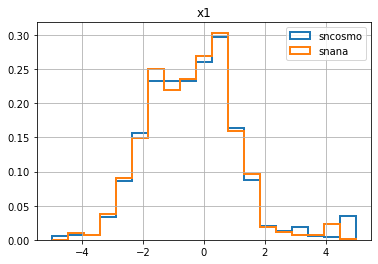

/home/mi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)
/home/mi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


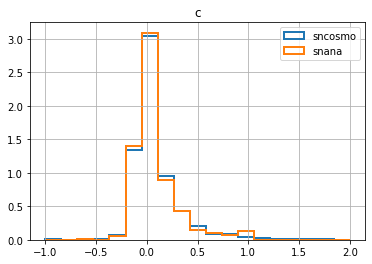

/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


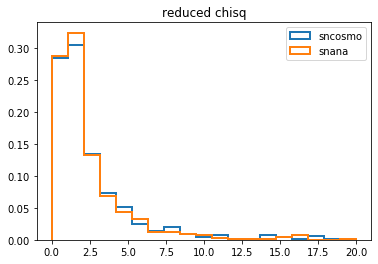

/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


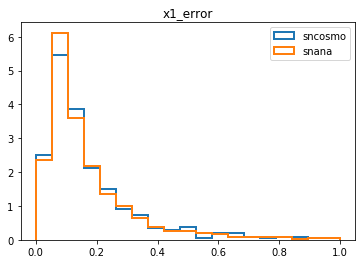

/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


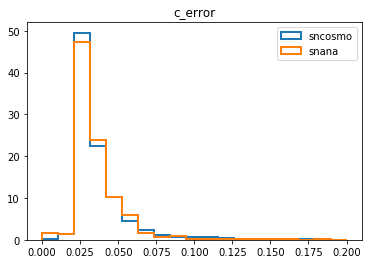

/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


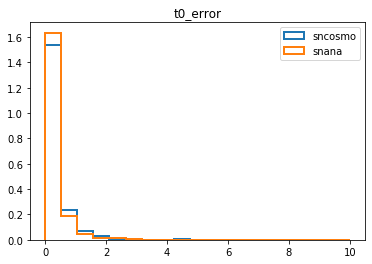

In [21]:
for p in ['x1','c']:
    for label,salt2p in zip(['sncosmo','snana'],[salt2par_sncosmo,salt2par_snana]): 
        if p == 'x1':
            bins = np.linspace(-5,5,20)
        else:
            bins = np.linspace(-1,2,20)
        salt2p[p].hist(bins=bins,normed=True,histtype='step',lw=2,label=label)
    plt.title(p)
    plt.legend()
    plt.show()
for label,salt2p in zip(['sncosmo','snana'],[salt2par_sncosmo,salt2par_snana]): 
    if label == 'sncosmo':
        reduced_chisq = salt2p['chisq']/salt2p['ndof']
    else:
        reduced_chisq = salt2p['FITCHI2']/salt2p['NDOF']
    plt.hist(reduced_chisq[np.isfinite(reduced_chisq)],bins=np.linspace(0,20,20),normed=True,histtype='step',lw=2,label=label)
plt.title('reduced chisq')
plt.legend()
plt.show()
for p in ['x1','c']:
    for label,salt2p in zip(['sncosmo','snana'],[salt2par_sncosmo,salt2par_snana]): 
        if label == 'sncosmo':
            perr = salt2p[p+'_err']
        else:
            perr = salt2p[p+'ERR']
        if p == 'x1':
            bins = np.linspace(0,1,20)
        else:
            bins = np.linspace(0,0.2,20)
        plt.hist(perr,bins=bins,normed=True,histtype='step',lw=2,label=label)
    plt.title(p+'_error')
    plt.legend()
    plt.show()
bins = np.linspace(0,10,20)
plt.hist(salt2par_sncosmo['t0_err'],label='sncosmo',bins=bins,histtype='step',normed=True,lw=2)
plt.hist(salt2par_snana['PKMJDERR'],label='snana',bins=bins,histtype='step',normed=True,lw=2)
plt.title('t0_error')
plt.legend()

In [6]:
df = salt2par_sncosmo.merge(salt2par_snana,on=['Name_upper','Survey'],suffixes=['_sncosmo','_snana'])

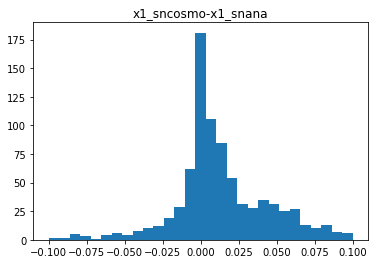

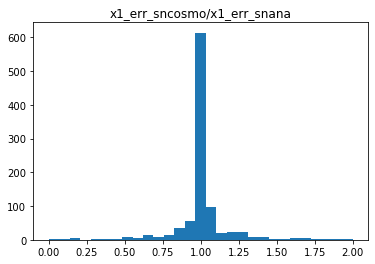

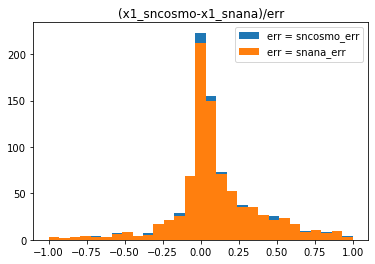

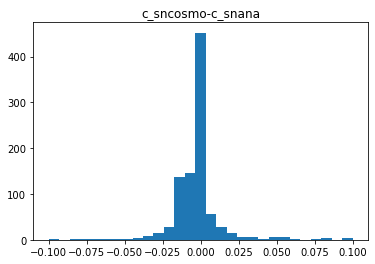

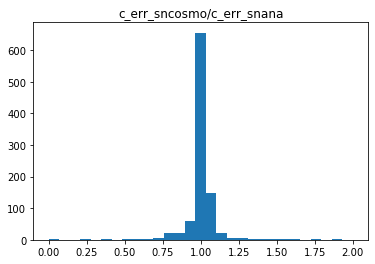

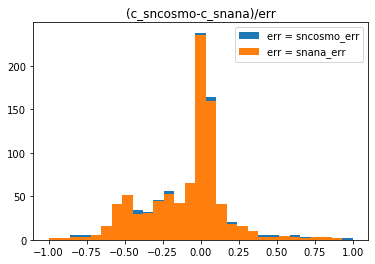

In [7]:
for p in ['x1','c']:
    plt.hist(df[p+'_sncosmo']-df[p+'_snana'],label=p,bins=np.linspace(-0.1,0.1,30))
    plt.title('{}_sncosmo-{}_snana'.format(p,p))
    plt.show()
    plt.hist(df[p+'_err']/df[p+'ERR'],bins=np.linspace(0,2,30))
    plt.title('{}_err_sncosmo/{}_err_snana'.format(p,p))
    plt.show()
    plt.hist((df[p+'_sncosmo']-df[p+'_snana'])/df[p+'_err'],bins=np.linspace(-1,1,30),label='err = sncosmo_err')
    plt.hist((df[p+'_sncosmo']-df[p+'_snana'])/df[p+'ERR'],bins=np.linspace(-1,1,30),label='err = snana_err')
    plt.title('({}_sncosmo-{}_snana)/err'.format(p,p))
    plt.legend()
    plt.show()

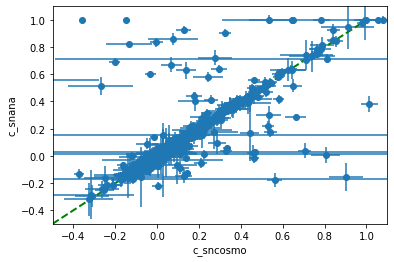

In [8]:
plt.errorbar(df['c_sncosmo'],df['c_snana'],xerr=df['c_err'],yerr=df['cERR'],fmt='o')
x = np.linspace(-0.5,1,100)
plt.plot(x,x,color='g',lw=2,ls='--')
plt.xlabel('c_sncosmo')
plt.ylabel('c_snana')
plt.xlim(-0.5,1.1)
plt.ylim(-0.5,1.1)
plt.show()

In [9]:
df.columns

Index(['Unnamed: 0', 'c_sncosmo', 'c_c_cov', 'c_err', 'c_mwebv_cov',
       'c_t0_cov', 'c_x0_cov', 'c_x1_cov', 'c_z_cov', 'chisq',
       ...
       'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2',
       'FITPROB', 'x0_offset', 'first_fitmjd_snana', 'last_fitmjd_snana'],
      dtype='object', length=103)

In [10]:
df[(np.absolute(df['mwebv']-df['MWEBV']))>1.e-5][['Name','mwebv','MWEBV']]

,Name,mwebv,MWEBV


In [11]:
df.loc[df['c_err']>0.5,'Name_upper'].unique()

array(['SN2008J', 'SN2008FF', 'SN2001C', 'SN2005EW', 'SN2008AD',
       'MASTERJ151647.17', 'SN1990T'], dtype=object)

In [12]:
df.loc[np.absolute(df['c_sncosmo']-df['c_snana'])>0.2,'Name_upper'].unique()

array(['SN2004DT', 'SN2005HK', 'SN2006X', 'SN2006BD', 'SN2006BR',
       'SN2006OT', 'SN2007AL', 'SN2007IF', 'SN2007SO', 'SN2008J',
       'SN2008AE', 'SN2008BI', 'SN2008CD', 'SN2008FF', 'SN2009I',
       'SN1998D', 'SN1999CL', 'SN1997CN', 'SN2001C', 'SN2001V',
       'SN2001FH', 'SN2001GB', 'SN2003CG', 'SN2006BZ', 'SN2006CM',
       'SN2006KE', 'SN2006MQ', 'SN2006OR', 'SN2007BJ', 'SN2007CF',
       'SN2007HG', 'SN2008AD', 'SN2008AI', 'SN2008BW', 'SN2008DT',
       'AT2016GKY', 'AT2016HNK', 'ASASSN-15SB', 'MASTERJ222232.87',
       'PS15CFN', 'SN2016BLH', 'SN2006E', 'SN2010IH', 'SN2011FE',
       'SN1990Y', 'SN1990T'], dtype=object)

In [22]:
# plotlist = ['SN2005KU']
# plotlist = df.loc[df['t0_err']>0.5,'Name_upper'].values
# plotlist = df.loc[np.absolute(df['c_sncosmo']-df['c_snana'])>0.2,'Name_upper'].unique()
plotlist = df.loc[(df['t0_err']>2) | (df['PKMJDERR']>2),'Name_upper'].values

In [23]:
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('plots/large_t0_err.pdf')
meta_df = pd.read_csv('data/snmeta_all.csv',index_col=0) 
lc_df = pd.read_csv('data/snlc_all.csv',index_col=0)
for i,name in enumerate(plotlist): #common_list:
    print(i,name)
    name = name.upper()
    meta,lc = ss.get_photometry_single_sn(name,df_meta=meta_df,df_lc=lc_df)
    for s in ss.commonElements([salt2par_sncosmo.loc[salt2par_sncosmo.Name_upper==name].Survey.unique(),
                                salt2par_snana.loc[salt2par_snana.Name_upper==name].Survey.unique()]):
        try:
            data = ss.convert_lc_for_sncosmo(lc.loc[lc.Survey==s],select_filts='BVRIgriz')
        except:
            print("failed to get photometry for {}, {}".format(name,s))
            continue
        psncosmo = salt2par_sncosmo.loc[(salt2par_sncosmo.Name_upper==name) & (salt2par_sncosmo.Survey==s)]
        psnana = salt2par_snana.loc[(salt2par_snana.Name_upper ==name) & (salt2par_snana.Survey==s)]
        models = []
        text = ','.join([name,s])
        text += '\n'
        for pname,source in zip([psncosmo,psnana],['sncosmo','snana']):
            pmap = ss.get_lcpar_map(source=source)
            model = ss.update_sncosmo_model(pname,pmap)
            models.append(model)
            text += '[{}] '.format(source)
            for p,v in zip(model.param_names,model.parameters):
                if p=='t0':
                    text += '{}={:.2f}, '.format(p,v) 
                else:
                    text += '{}={:.4f}, '.format(p,v)
            if source == 'sncosmo':
                text += 'fitbands={}, '.format(pname['bands'].values[0].strip())
                text += '\nchisq={:.2f}, '.format(pname['chisq'].values[0])
                text += 'ndof={}, '.format(pname['ndof'].values[0])
                text += 'reduced_chisq={:.2f}, '.format(pname['chisq'].values[0]/pname['ndof'].values[0])
            elif source == 'snana':
                text += '\nchisq={:.2f}, '.format(pname['FITCHI2'].values[0])
                text += 'ndof={}, '.format(pname['NDOF'].values[0])
                text += 'reduced_chisq={:.2f}, '.format(pname['FITCHI2'].values[0]/pname['NDOF'].values[0])
            text += 'first_fitmjd={:.2f}, '.format(pname['first_fitmjd'].values[0])
            text += 'last_fitmjd={:.2f}'.format(pname['last_fitmjd'].values[0])
            text += '\n'
            
            data_chisq = data[[x.split('-')[1][0] in 'BVRIgriz' for x in data['Filter']]]

        fig = ss.compare_model_sncosmo(data=data,models=models,model_label=['sncosmo','snana'],figtext=text,
                                       fname=pdf, format='pdf')
pdf.close()

/home/mi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


0 SN2008J
1 SN2008FF
2 SN1998D
3 SN1998EG
4 SN2001C
5 SN2001IC
Error in CfA3-R4Shooter band lc
6 SN2003K
7 SN2003AI
8 SN2005EW
9 SN2006AH
10 SN2006CT
11 SN2008AD
12 SN2016EJA
13 ATLAS16EEJ
14 SN2001BP
15 ASASSN-14AD
16 LSQ13CRF
17 LSQ11OT
18 ASASSN-15TS
19 SN1993AH
20 SN1990T
